In [62]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb  
sb.set_style('darkgrid')
from scipy import stats
from statsmodels.graphics.api import qqplot

In [8]:
daily_data = pd.read_csv('./exchangeratedata/daily_rates.csv', skiprows=3, header=0)
monthly_data = pd.read_csv('./exchangeratedata/monthly_rates.csv', skiprows=11, header=0)

In [9]:
daily_data['datetime'] = pd.to_datetime(daily_data['DATE'])
daily_data['dayofweek'] = daily_data['datetime'].apply(lambda row: row.dayofweek)
weekly_data = daily_data[daily_data['dayofweek'] == 4]



In [10]:
print weekly_data.head(5)

           DATE  XUDLERS  XUDLUSS   datetime  dayofweek
3   07 Jan 2000   1.5909   1.6372 2000-01-07          4
8   14 Jan 2000   1.6152   1.6349 2000-01-14          4
13  21 Jan 2000   1.6391   1.6506 2000-01-21          4
18  28 Jan 2000   1.6529   1.6198 2000-01-28          4
23  04 Feb 2000   1.6214   1.5886 2000-02-04          4


In [12]:
UK_US = pd.DataFrame()
UK_US['UK_US']=weekly_data['XUDLUSS']
# UK_US['LIBOR']=weekly_data['IUDSOIA']
# UK_US['forward_UK_US_1mo']=weekly_data['XUDLDS1']
UK_US['datetime']=weekly_data['datetime']
UK_US = UK_US.reset_index(drop=True)

UK_EU = pd.DataFrame()
UK_EU['UK_EU']=weekly_data['XUDLERS']
# UK_EU['LIBOR']=weekly_data['IUDSOIA']
# UK_EU['forward_UK_US_1mo']=weekly_data['XUDLDS1']
UK_EU['datetime']=weekly_data['datetime']
UK_EU = UK_EU.reset_index(drop=True)



In [13]:
full = pd.DataFrame()
full['UK_US']=weekly_data['XUDLUSS']
# full['LIBOR']=weekly_data['IUDSOIA']
# full['forward_UK_US_1mo']=weekly_data['XUDLDS1']
full['datetime']=weekly_data['datetime']
full['UK_EU']=weekly_data['XUDLERS']
full = full.reset_index(drop=True)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


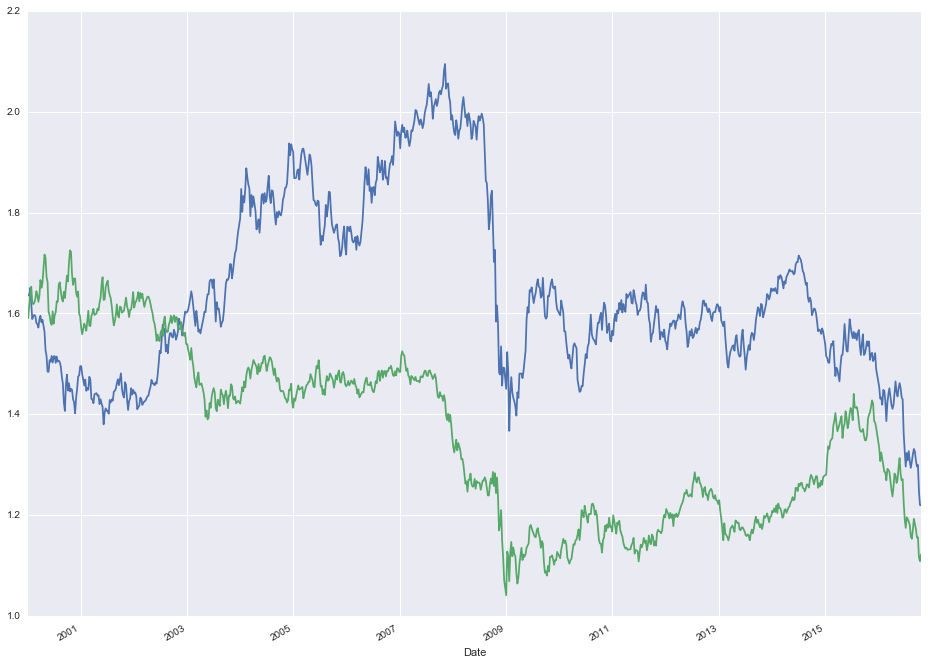

In [14]:
full['Date'] = full['datetime'].convert_objects(convert_dates='coerce')  
full = full.sort_index(by='Date')  
full = full.set_index('Date')  
full['UK_US'].plot(figsize=(16, 12))  
full['UK_EU'].plot(figsize=(16, 12)) 





## Check if data has gaussian distribution

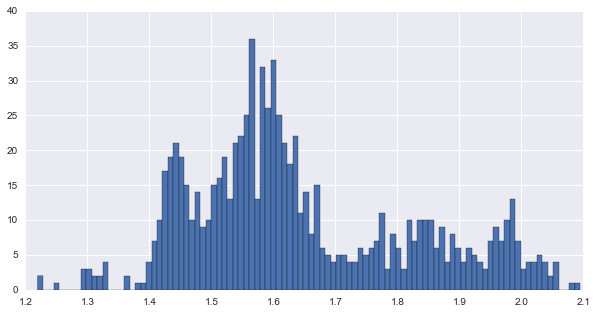

In [16]:
full['UK_US'].hist(figsize=(10, 5), bins=100)   

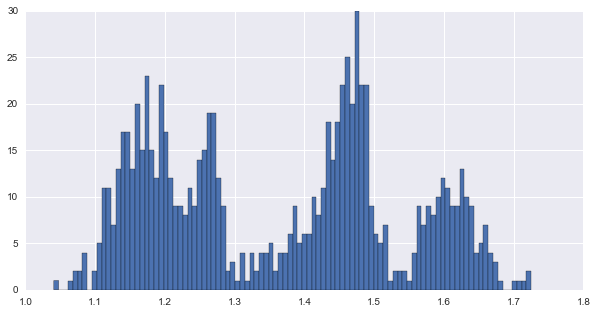

In [17]:
full['UK_EU'].hist(figsize=(10, 5), bins=100)

In [18]:
# full['LIBOR'].plot(figsize=(16, 12)) 

In [19]:
# full['forward_UK_US_1mo'].plot(figsize=(16, 12)) 
# full['UK_US'].plot(figsize=(16, 12)) 
# full[['UK_US', 'forward_UK_US_1mo']].iloc[100:160, :].plot(figsize=(16, 12))  
# full[['UK_US', 'forward_UK_US_1mo']].iloc[800:860, :].plot(figsize=(16, 12))  


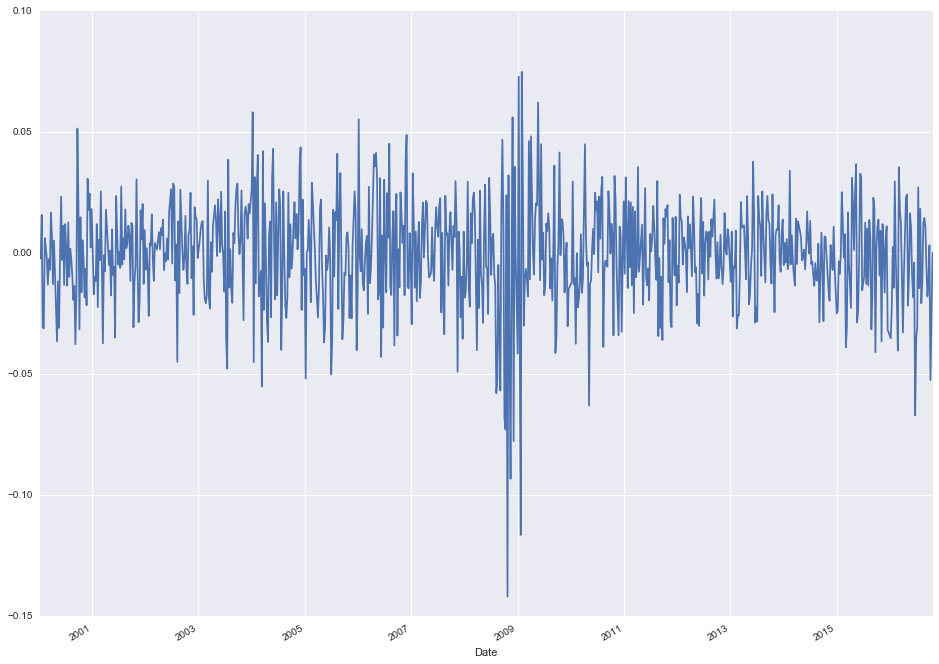

In [27]:
full['first_diff_uk_us'] = full['UK_US'] - full['UK_US'].shift()  
full['first_diff_uk_us'].plot(figsize=(16, 12))  

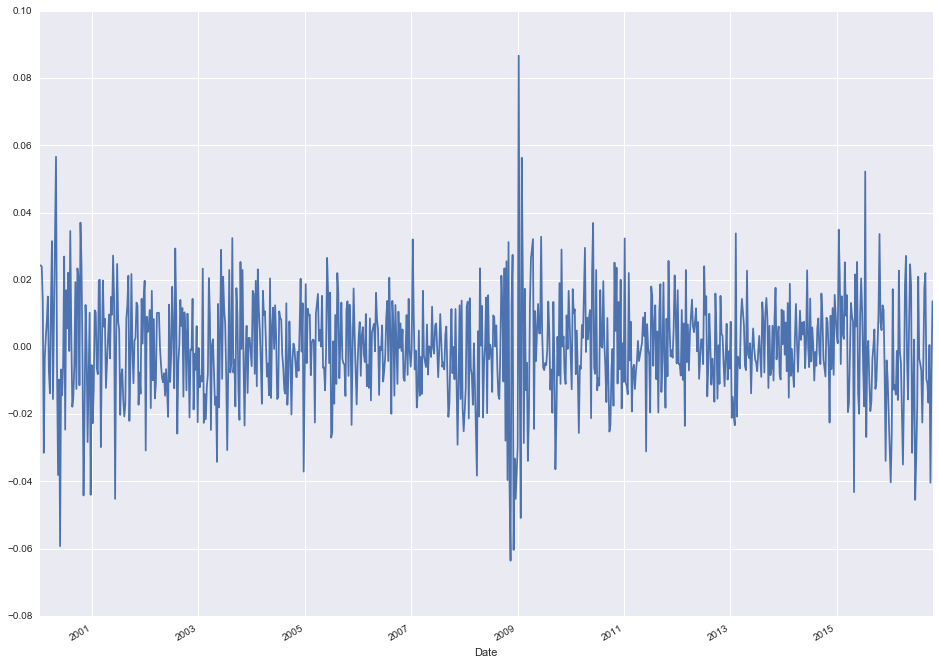

In [28]:
full['first_diff_uk_eu'] = full['UK_EU'] - full['UK_EU'].shift()  
full['first_diff_uk_eu'].plot(figsize=(16, 12))   

In [20]:
# full['first_diff_libor'] = full['LIBOR'] - full['LIBOR'].shift()  
# full['first_diff_libor'].plot(figsize=(16, 12))   

In [22]:
# full['var_uk_us'] = pd.rolling_var(full['UK_US'], 4, min_periods=None, freq=None, center=True)  
# full['var_uk_eu'] = pd.rolling_var(full['UK_EU'], 4, min_periods=None, freq=None, center=True)  
# full['var_libor'] = pd.rolling_var(full['LIBOR'], 4, min_periods=None, freq=None, center=True) 

In [23]:
# fig, ax = plt.subplots(3, 1, figsize=(13, 12))  
# full['var_uk_us'].plot(ax=ax[0], title='UK/US exchange rate rolling variance')  
# full['var_uk_eu'].plot(ax=ax[1], title='UK/EU exchange rate rolling variance')  
# full['var_libor'].plot(ax=ax[2], title='Overnight LIBOR rolling variance')  
# fig.tight_layout()  

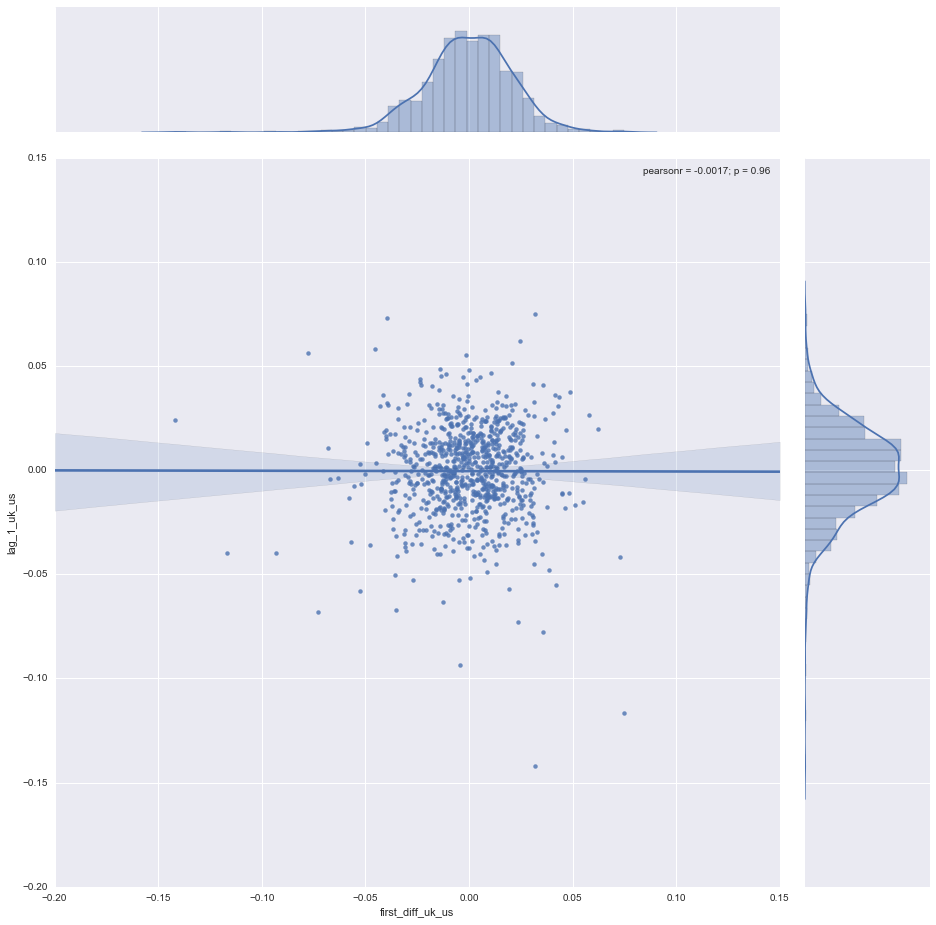

In [29]:
full['lag_1_uk_us'] = full['first_diff_uk_us'].shift()  
sb.jointplot('first_diff_uk_us', 'lag_1_uk_us', full, kind='reg', size=13) 


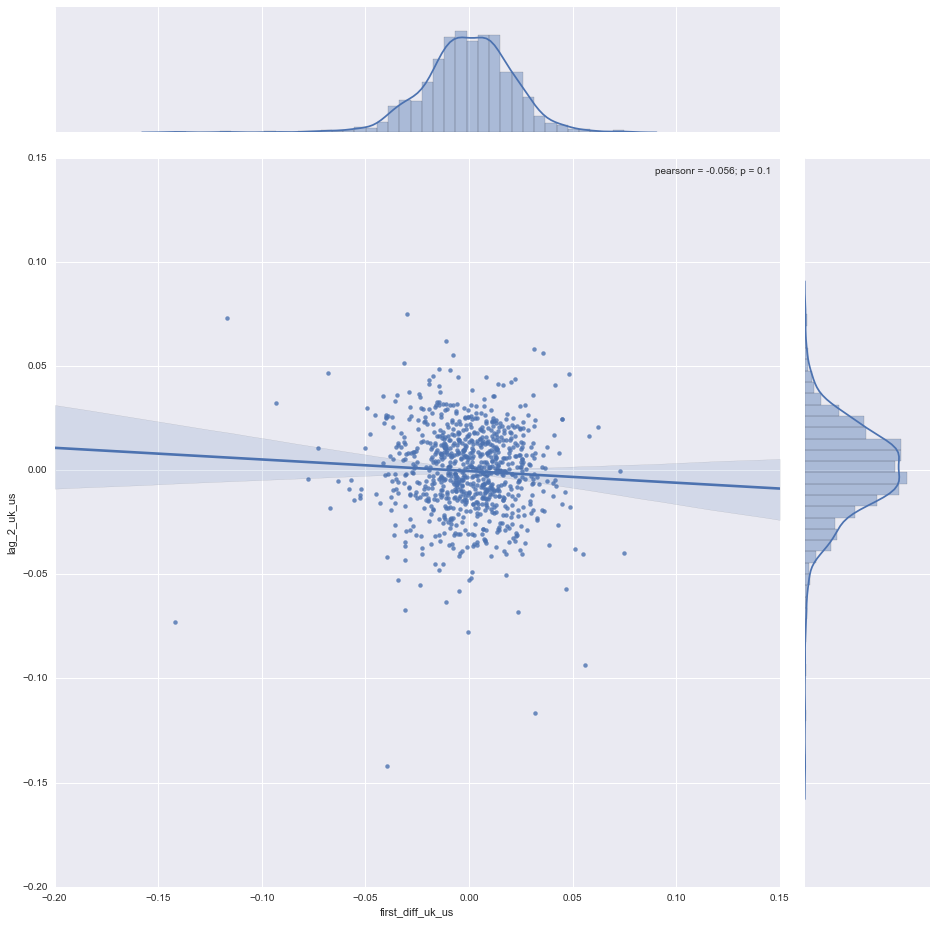

In [30]:
full['lag_2_uk_us'] = full['first_diff_uk_us'].shift(2)  
sb.jointplot('first_diff_uk_us', 'lag_2_uk_us', full, kind='reg', size=13) 

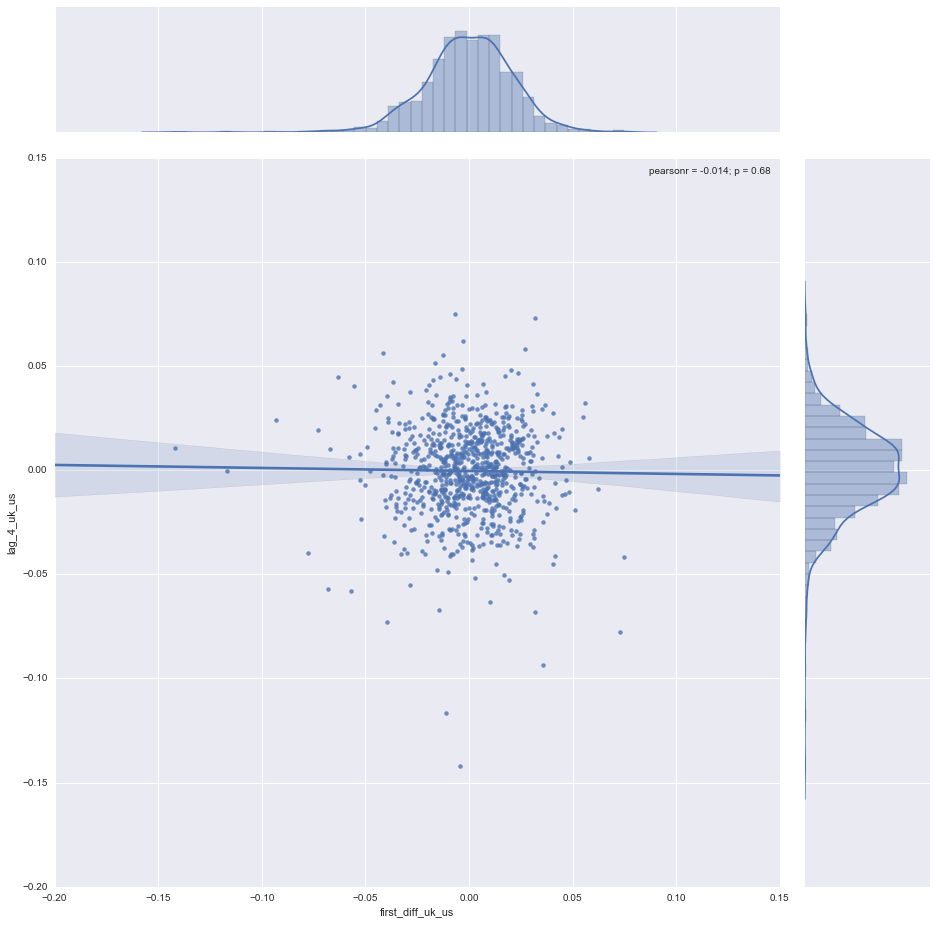

In [31]:
full['lag_4_uk_us'] = full['first_diff_uk_us'].shift(4)  
sb.jointplot('first_diff_uk_us', 'lag_4_uk_us', full, kind='reg', size=13) 

In [24]:
# lag_correlations_UK_US = acf(full['first_diff_uk_us'].iloc[1:])  
# fig, ax = plt.subplots(figsize=(16,12))  
# ax.plot(lag_correlations_UK_US, marker='o', linestyle='--')  

## Autocorrelation plots of the exchange rate

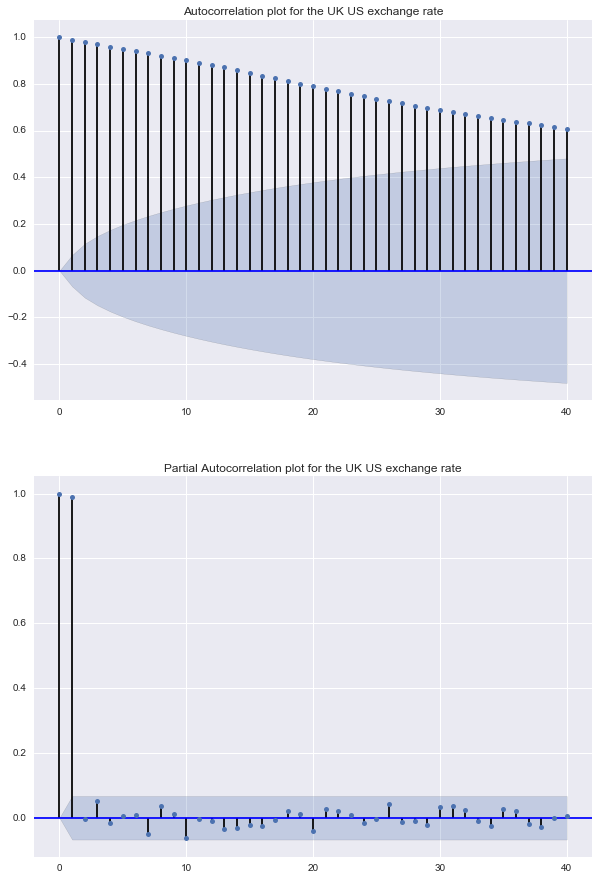

In [44]:
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(full['UK_US'].values, lags=40, ax=ax1)
ax1.set_title('Autocorrelation plot for the UK US exchange rate')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(full['UK_US'].values, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation plot for the UK US exchange rate')

## Autocorrelation plots of the first difference

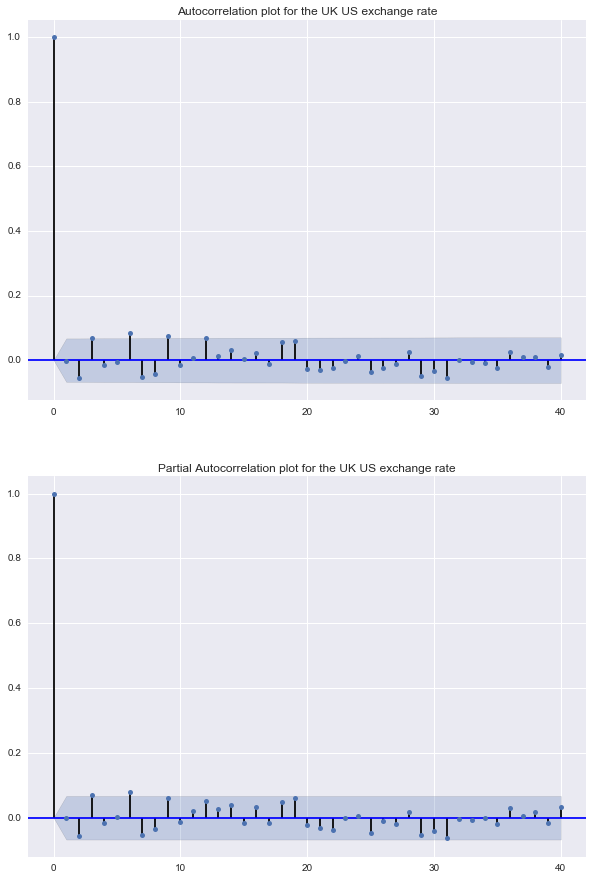

In [50]:
fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(full['first_diff_uk_us'][1:].values, lags=40, ax=ax1)
ax1.set_title('Autocorrelation plot for the UK US exchange rate')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(full['first_diff_uk_us'][1:].values, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation plot for the UK US exchange rate')

In [100]:
full.head(20)

,UK_US,datetime,UK_EU,first_diff_uk_us,first_diff_uk_eu,lag_1_uk_us,lag_2_uk_us,lag_4_uk_us
Date,,,,,,,,
2000-01-07,1.6372,2000-01-07,1.5909,NaN,NaN,NaN,NaN,NaN
2000-01-14,1.6349,2000-01-14,1.6152,-0.0023,0.0243,NaN,NaN,NaN
2000-01-21,1.6506,2000-01-21,1.6391,0.0157,0.0239,-0.0023,NaN,NaN
2000-01-28,1.6198,2000-01-28,1.6529,-0.0308,0.0138,0.0157,-0.0023,NaN
2000-02-04,1.5886,2000-02-04,1.6214,-0.0312,-0.0315,-0.0308,0.0157,NaN
2000-02-11,1.5947,2000-02-11,1.6182,0.0061,-0.0032,-0.0312,-0.0308,-0.0023
2000-02-18,1.5969,2000-02-18,1.6212,0.0022,0.0030,0.0061,-0.0312,0.0157
2000-02-25,1.5945,2000-02-25,1.6289,-0.0024,0.0077,0.0022,0.0061,-0.0308
2000-03-03,1.5813,2000-03-03,1.6439,-0.0132,0.0150,-0.0024,0.0022,-0.0312


In [175]:
arma_mod20 = sm.tsa.ARMA(full['UK_US'].values, (2,0), dates=pd.DatetimeIndex(full['datetime'][1:].values)).fit()
print arma_mod20.params

[ 1.58156765  0.99622282 -0.00206415]


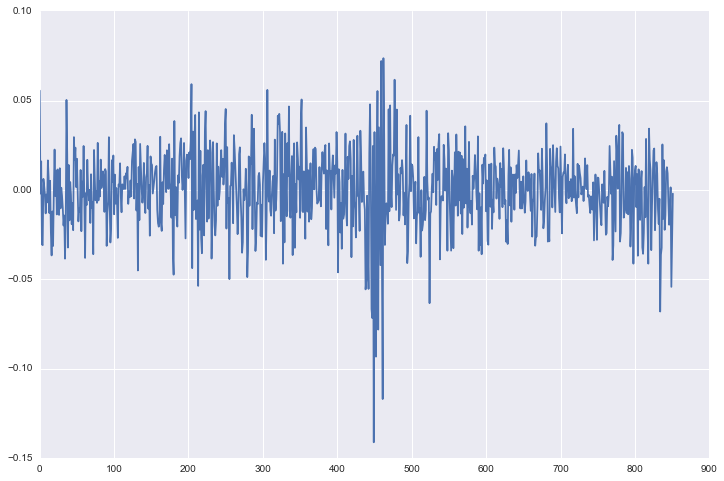

In [143]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(arma_mod20.resid)

In [145]:
# Given the null hypothesis that x came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen.
#  If the p-val is very small, it means it is unlikely that the data came from a normal distribution
stats.normaltest(arma_mod20.resid)
resid = arma_mod20.resid
resid

array([  5.56323486e-02,  -1.97570253e-03,   1.60162794e-02,
        -3.04291665e-02,  -3.09130964e-02,   6.20547982e-03,
         2.26411904e-03,  -2.31497984e-03,  -1.31195039e-02,
        -2.57431663e-03,  -7.01138410e-03,   1.65568089e-02,
         6.90506094e-03,  -1.29346116e-02,   5.13052774e-03,
        -2.34770426e-02,  -3.66552791e-02,  -1.20420314e-02,
        -3.13621500e-02,  -9.03599526e-04,   2.26309009e-02,
        -3.38229428e-03,   1.07546402e-02,  -1.37090414e-02,
         1.14638406e-02,   7.81335815e-04,  -1.39895682e-02,
         1.21615392e-02,  -1.03189408e-02,   1.26967344e-03,
        -3.14434046e-03,  -9.95102978e-03,  -1.98924862e-02,
        -1.42853729e-02,  -3.84771647e-02,  -1.75482209e-02,
         5.04106753e-02,   1.97703508e-02,  -3.22457419e-02,
         1.39774208e-02,  -1.70322819e-02,   4.43649319e-03,
        -2.77751117e-03,  -1.91743319e-02,  -7.44796030e-03,
        -2.25108701e-02,   2.95939195e-02,   1.68649154e-02,
         2.36953122e-02,

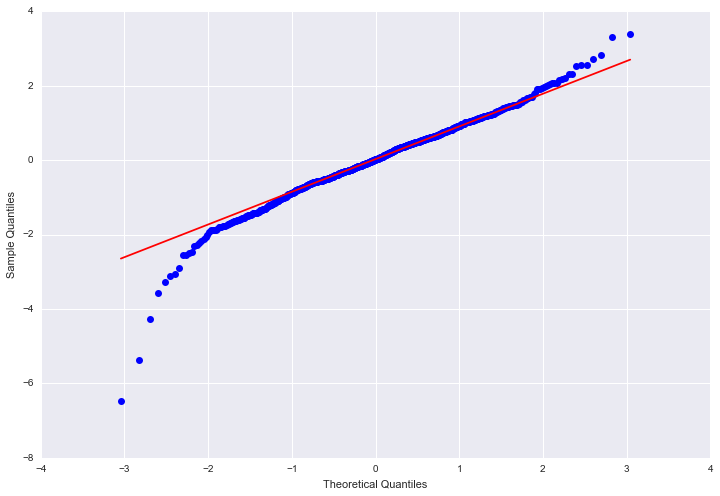

In [146]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(arma_mod20.resid, line='q', ax=ax, fit=True)

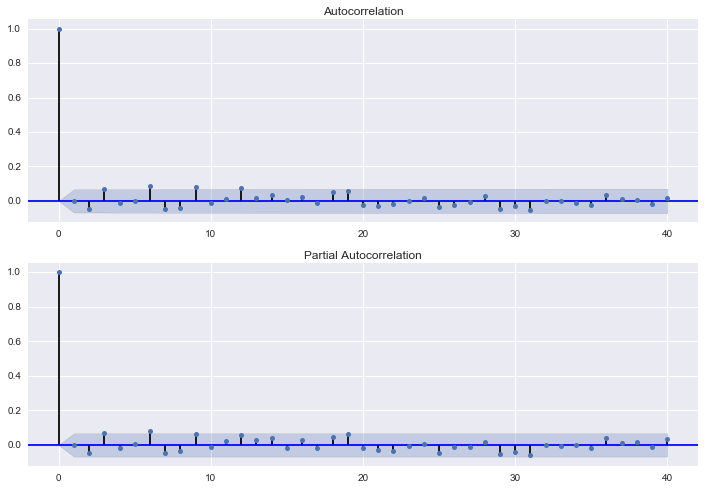

In [147]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [169]:
n_weeks = len(full['datetime'])
date_1 = full['datetime'][300]
date_2 = full['datetime'][500]
start = full['datetime'][n_weeks-10]
date_1, date_2

(Timestamp('2005-11-25 00:00:00'), Timestamp('2009-10-30 00:00:00'))

In [176]:
import datetime
delta = datetime.timedelta(weeks=3)
end  = start + delta
predict_ex = arma_mod20.predict(start, end)

ValueError: When freq is None, you must give an integer index for end.

13 13


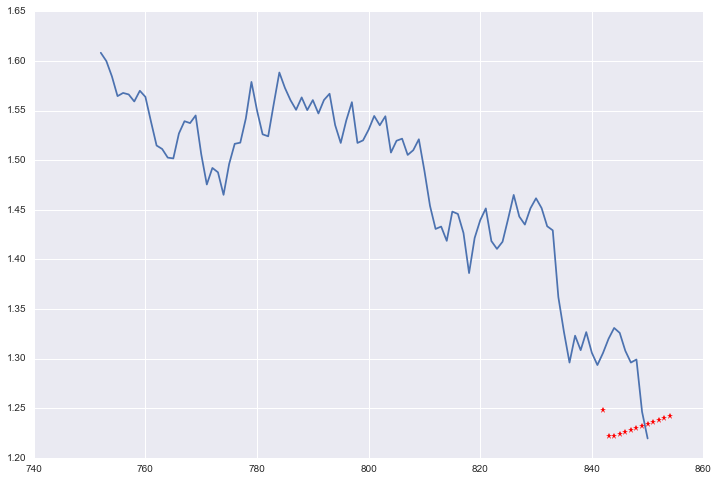

In [51]:
# decomposition_UK_US = seasonal_decompose(full['first_diff_uk_us'][1:], model='additive', freq=52)  
# fig = plt.figure()  
# fig = decomposition_UK_US.plot() 
# #plt.plot(decomposition_UK_US.trend)
# #trend = pd.DataFrame(decomposition_UK_US.trend)


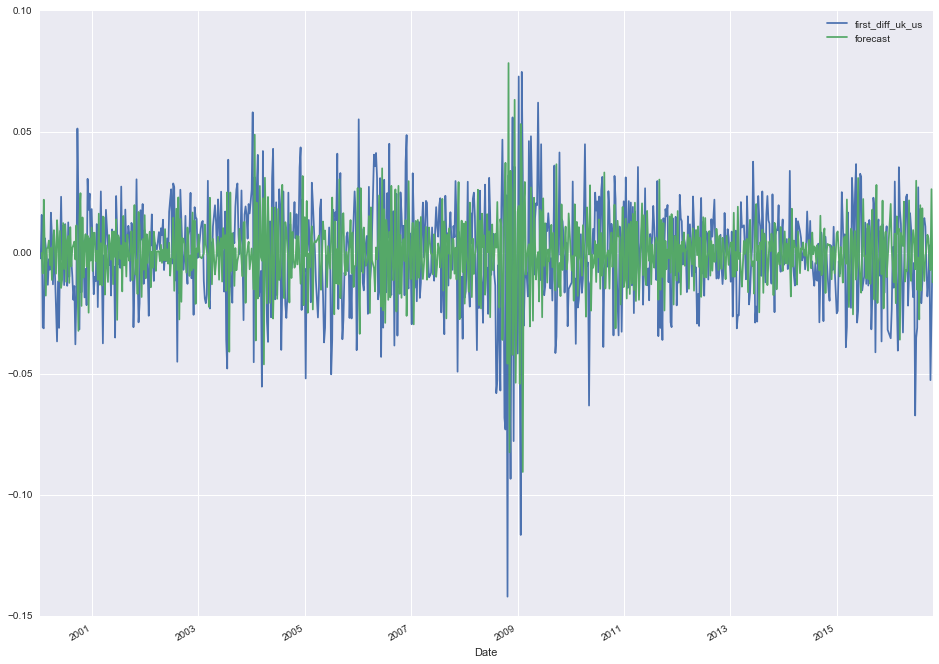

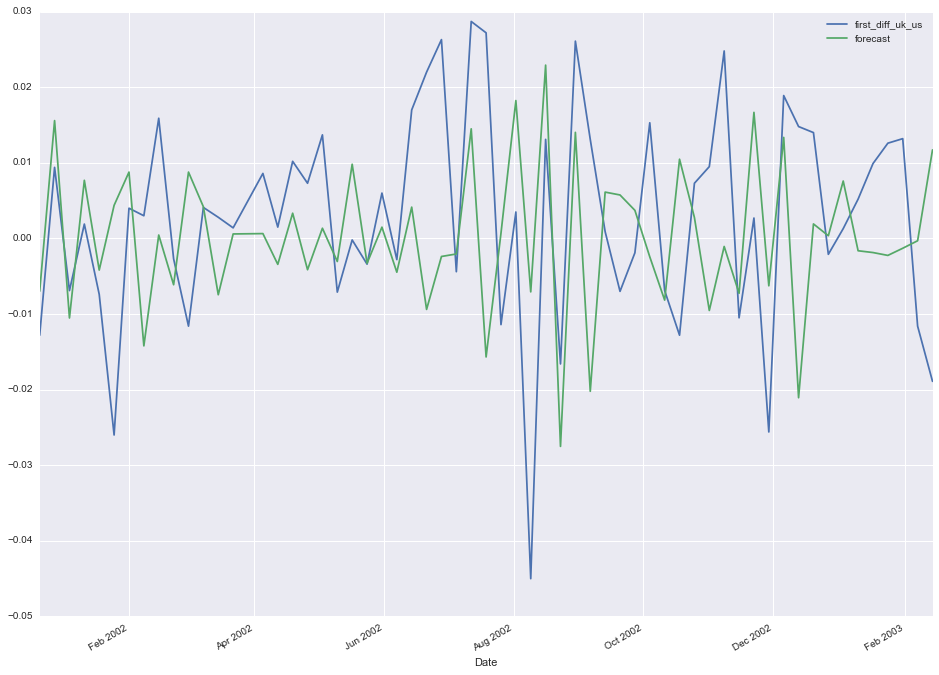

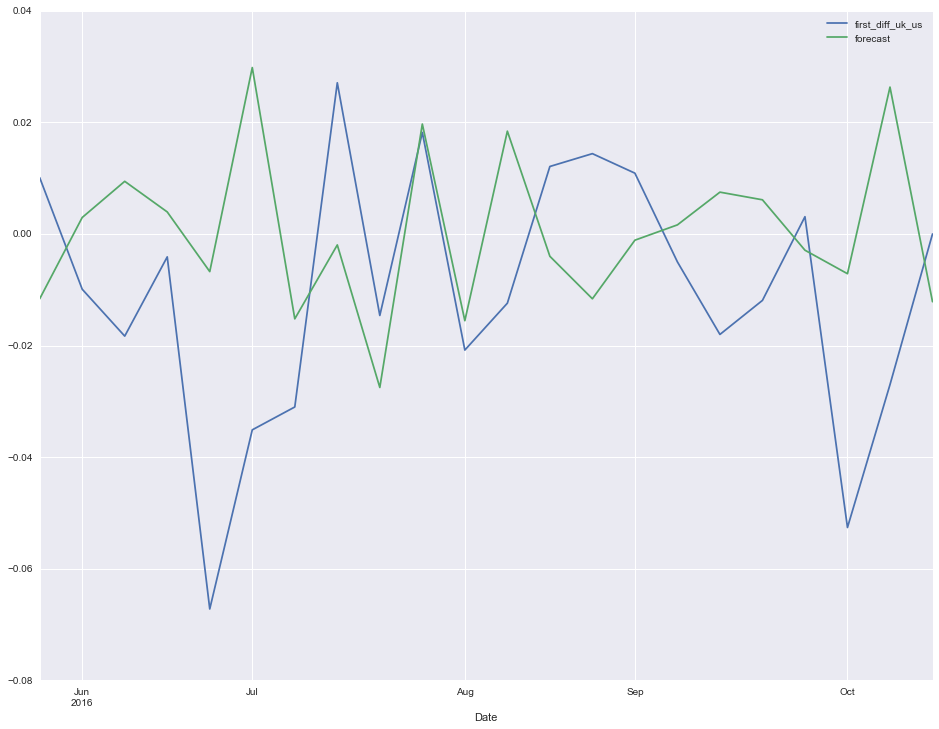

In [43]:
model_UK_US = sm.tsa.ARIMA(full['first_diff_uk_us'].iloc[1:], order=(1, 1, 0), dates=full['datetime'])  
results = model_UK_US.fit(disp=-1)  
full['forecast'] = results.fittedvalues  
full[['first_diff_uk_us', 'forecast']].plot(figsize=(16, 12))  
full[['first_diff_uk_us', 'forecast']].iloc[100:160, :].plot(figsize=(16, 12))  
full[['first_diff_uk_us', 'forecast']].iloc[830:860, :].plot(figsize=(16, 12))  

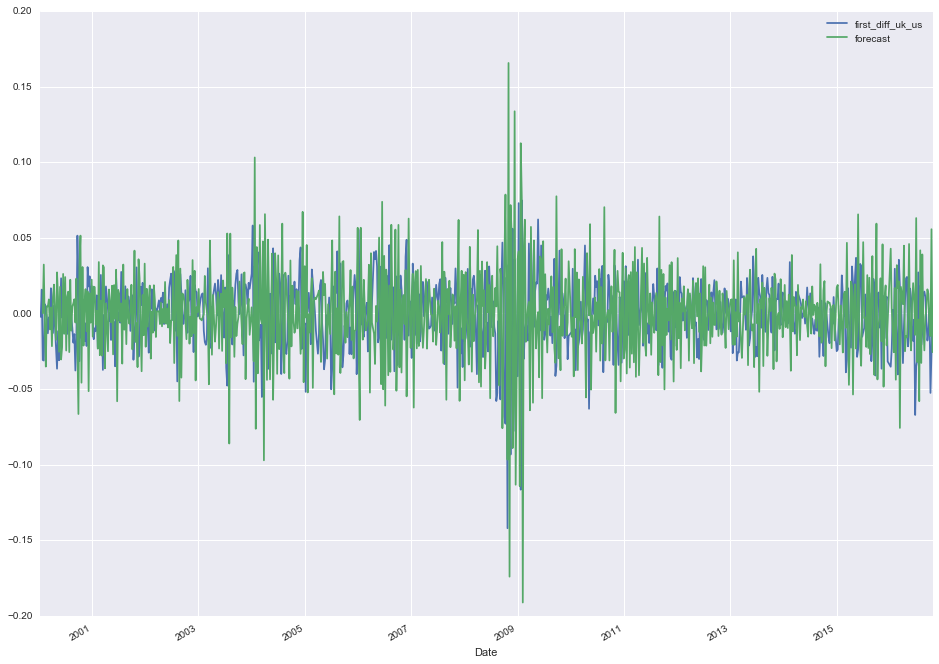

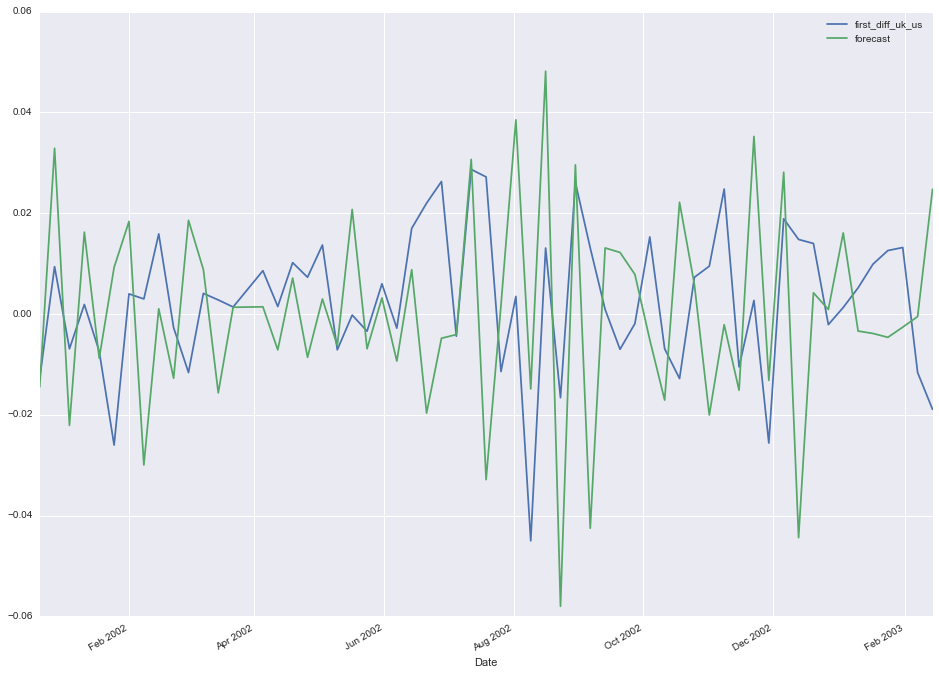

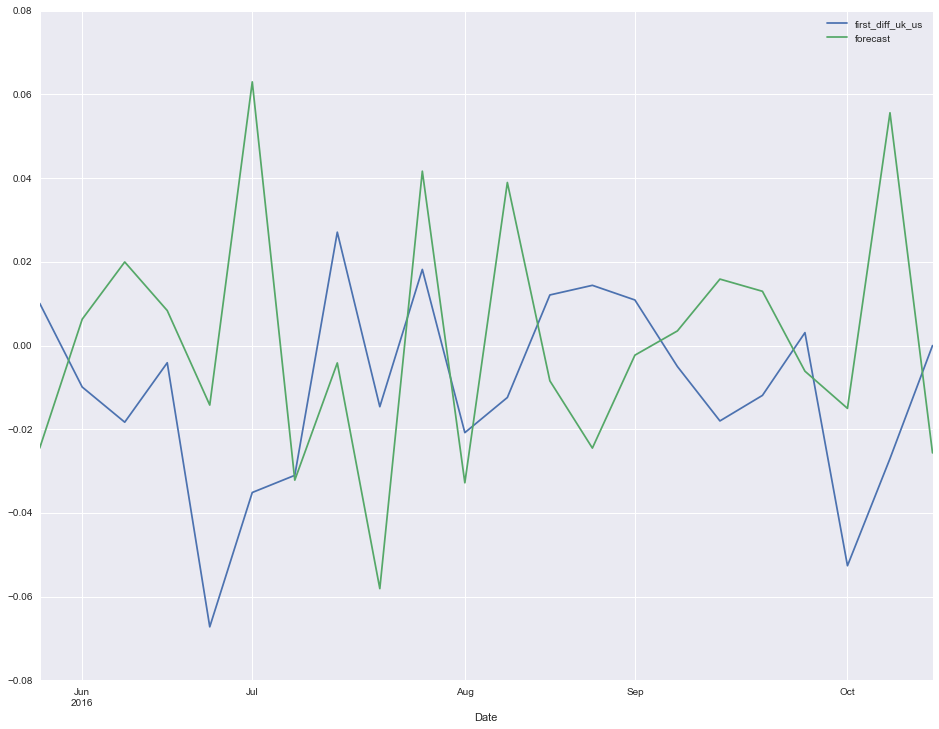

In [44]:
model_UK_US = sm.tsa.ARIMA(full['first_diff_uk_us'].iloc[1:], order=(0, 2, 1), dates=full['datetime'])  
results = model_UK_US.fit(disp=-1)  
full['forecast'] = results.fittedvalues  
full[['first_diff_uk_us', 'forecast']].plot(figsize=(16, 12))  
full[['first_diff_uk_us', 'forecast']].iloc[100:160, :].plot(figsize=(16, 12))  
full[['first_diff_uk_us', 'forecast']].iloc[830:860, :].plot(figsize=(16, 12)) 

In [155]:
print(results.params)

const                      -0.000014
ar.L1.D.First Difference   -0.473027
dtype: float64


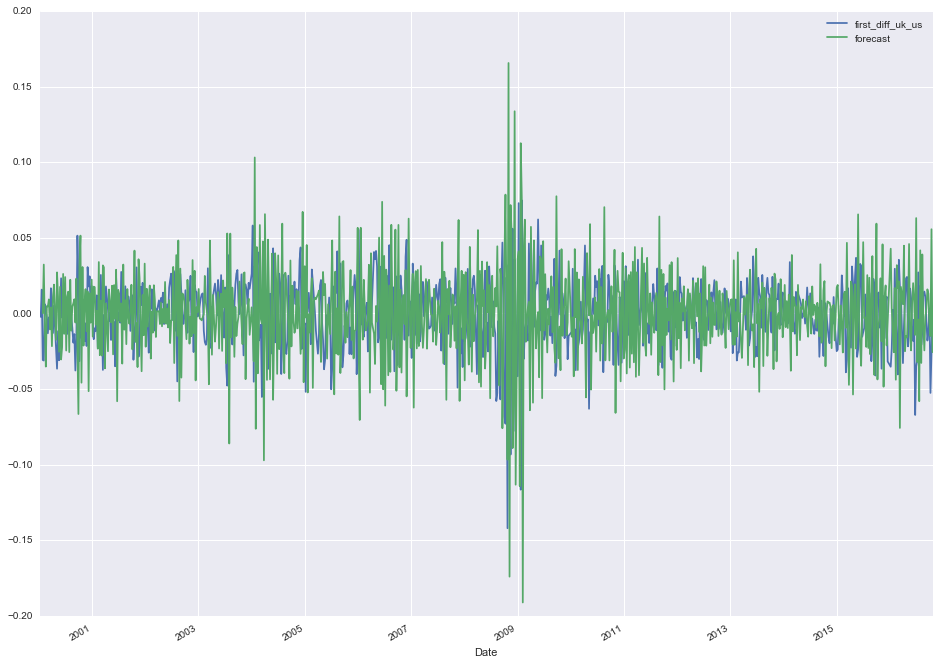

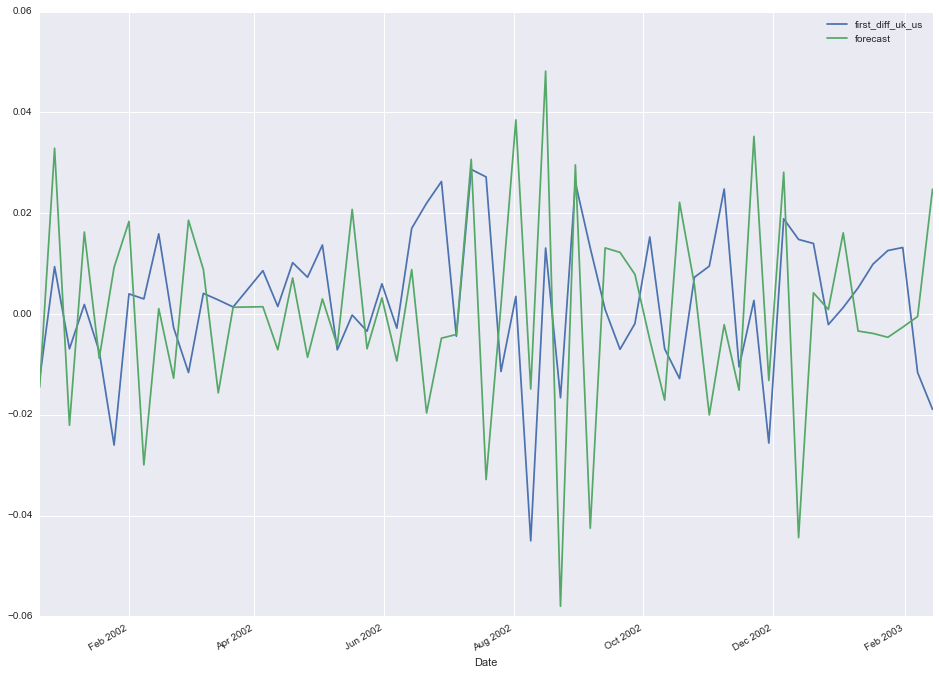

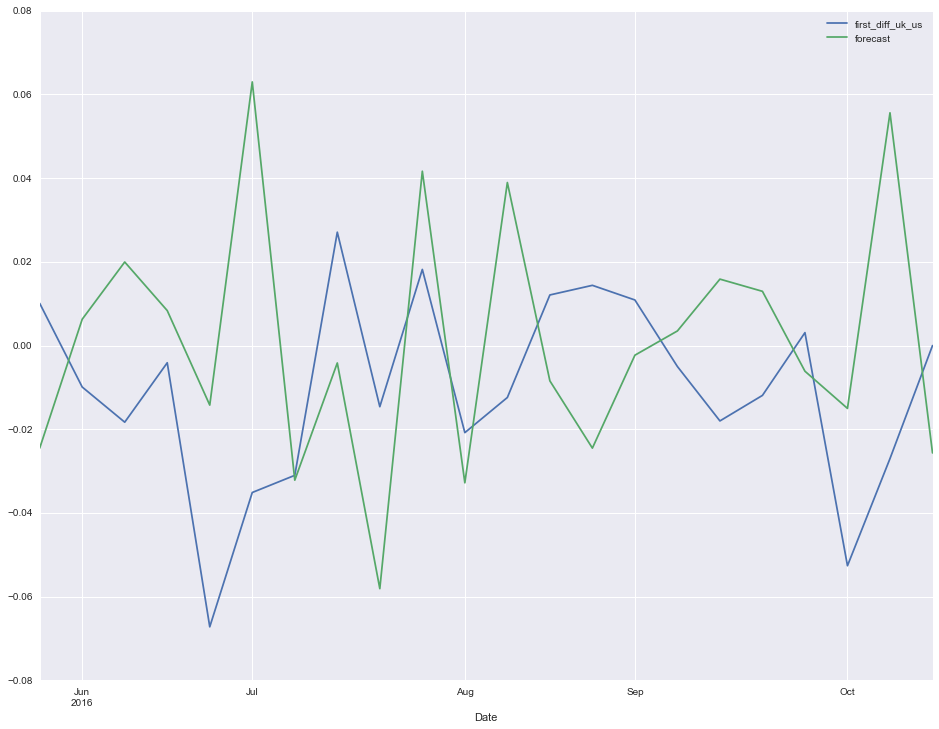

In [49]:
model_UK_US = sm.tsa.ARIMA(full['first_diff_uk_us'].iloc[1:], order=(0, 2, 1), 
                           dates=full['datetime'], exog=(full['first_diff_libor'].iloc[1:]))  
results = model_UK_US.fit(disp=-1)  
full['forecast'] = results.fittedvalues  
full[['first_diff_uk_us', 'forecast']].plot(figsize=(16, 12))  
full[['first_diff_uk_us', 'forecast']].iloc[100:160, :].plot(figsize=(16, 12))  
full[['first_diff_uk_us', 'forecast']].iloc[830:860, :].plot(figsize=(16, 12))

In [50]:
print(results.params)

const                       -1.004619e-07
first_diff_libor            -1.147551e-05
ma.L1.D2.first_diff_uk_us   -9.999463e-01
dtype: float64


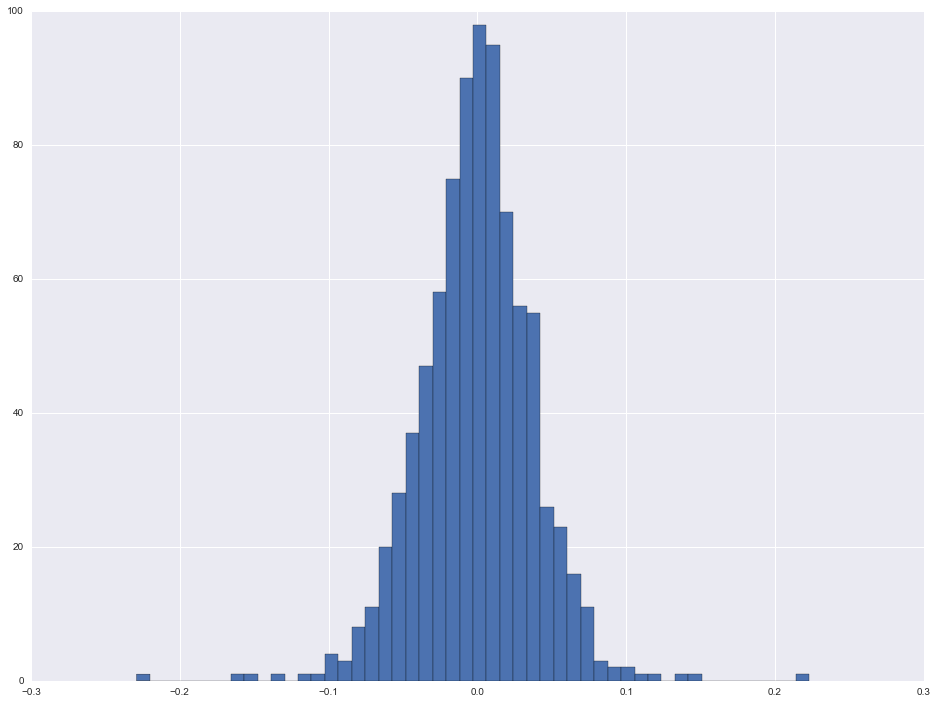

In [86]:
full['residuals_arma_0_2_1_libor']=full['first_diff_uk_us']-full['forecast']
#full['residuals_arma_0_2_1_libor'].plot(figsize=(16, 12))
full['residuals_arma_0_2_1_libor'].hist(figsize=(16, 12), bins=50)
#full['first_diff_uk_us'].plot(figsize=(16, 12))